In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
assets = ['AXP', 'GS', 'JPM', 'V']

In [3]:
weights = np.array([0.25,0.25,0.25,0.25])

In [4]:
stockStartDate = '2013-01-01'

In [5]:
today = datetime.today().strftime('%Y-%m-%d')
today

'2022-02-02'

In [6]:
df = pd.DataFrame()
for stock in assets:
    df[stock] = web.DataReader(stock, data_source = 'yahoo', start = stockStartDate, end = today)['Adj Close']

In [7]:
 df

,AXP,GS,JPM,V
Date,,,,
2013-01-02,51.604919,114.174713,34.937061,36.500900
2013-01-03,51.824509,113.550339,34.866638,36.529083
2013-01-04,52.360332,116.646240,35.484646,36.827427
2013-01-07,52.579926,116.429413,35.523766,37.090534
2013-01-08,52.878571,115.380096,35.594170,37.435848
...,...,...,...,...
2022-01-26,175.320007,342.679993,147.919998,205.869995
2022-01-27,171.899994,341.029999,145.309998,206.149994
2022-01-28,177.059998,347.010010,146.610001,228.000000


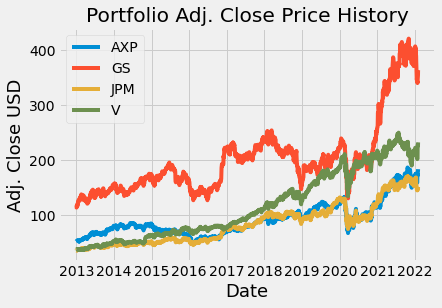

In [8]:
title = 'Portfolio Adj. Close Price History'
my_stocks = df

for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label = c)

plt.title(title)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj. Close USD', fontsize = 18)
plt.legend(my_stocks.columns.values, loc= 'upper left')
plt.show()

In [9]:
returns = df.pct_change()
returns

,AXP,GS,JPM,V
Date,,,,
2013-01-02,NaN,NaN,NaN,NaN
2013-01-03,0.004255,-0.005469,-0.002016,0.000772
2013-01-04,0.010339,0.027265,0.017725,0.008167
2013-01-07,0.004194,-0.001859,0.001102,0.007144
2013-01-08,0.005680,-0.009012,0.001982,0.009310
...,...,...,...,...
2022-01-26,0.012766,0.003308,0.009486,0.019158
2022-01-27,-0.019507,-0.004815,-0.017645,0.001360
2022-01-28,0.030017,0.017535,0.008946,0.105991


In [10]:
#annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,AXP,GS,JPM,V
AXP,0.085838,0.056256,0.057510,0.045731
GS,0.056256,0.077733,0.062060,0.039003
JPM,0.057510,0.062060,0.070372,0.037676
V,0.045731,0.039003,0.037676,0.061038


In [11]:
#calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights) )
port_variance

0.05571582251754264

In [12]:
#calculate the portfolio volatility(std dev)
port_volatality = np.sqrt(port_variance)
port_volatality

0.23604199312313612

In [13]:
#calculate annual portfolio returns
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.19497551858401393

In [14]:
#show the expected annual return, volatility(risk), variance
percent_var  = str(round(port_variance, 2) * 100) + '%'
percent_vols  = str(round(port_volatality, 2) * 100) + '%'
percent_ret  = str(round(portfolioSimpleAnnualReturn, 2) * 100) + '%'

print('Expected Annual Return:' + percent_ret)
print('Annual Volatility/Risk:' + percent_vols)
print('Annual Variance:' + percent_var)

Expected Annual Return:19.0%
Annual Volatility/Risk:24.0%
Annual Variance:6.0%


In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [16]:
#Portfolio Optimization

#calculate the expected returns and annualized sample covariance matrix of asset returns

mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('AXP', 0.0), ('GS', 0.0), ('JPM', 0.16395), ('V', 0.83605)])
Expected annual return: 21.8%
Annual volatility: 23.4%
Sharpe Ratio: 0.84


(0.21786391797411772, 0.23427463292811443, 0.8445810607025086)

In [17]:
#Discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 1000000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation:', allocation)
print('Funds Remaining : ${:2f}'.format(leftover))

Long-step dual simplex will be used
Discrete Allocation: {'JPM': 1084, 'V': 3598}
Funds Remaining : $122.124420
